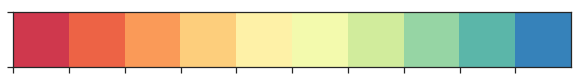

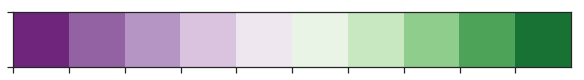

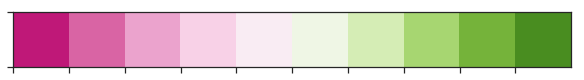

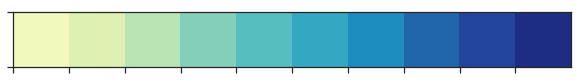

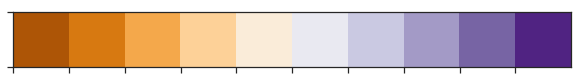

In [160]:
%matplotlib inline
import ast
from bs4 import BeautifulSoup
from config import api_key_tmdb
import csv
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import re
import requests
from scipy import stats
import seaborn as sns
sns.palplot(sns.color_palette("Spectral", 10))
sns.palplot(sns.color_palette("PRGn", 10))
sns.palplot(sns.color_palette("PiYG", 10))
sns.palplot(sns.color_palette("YlGnBu", 10))
sns.palplot(sns.color_palette("PuOr", 10))
import sqlite3
from sqlite3 import Error
import time
from wordcloud import WordCloud, STOPWORDS

In [161]:
# Importing the IMDB movies file
data = "/Users/florencialeoni/Documents/flatironDS/Mod_1_FP/mod1_movies/imdb_movies_data.csv"
use_cols = ["imdb_id", "imdb_score", "meta_score"]

# Using pandas.read_csv method to load the file
imdb_df = pd.read_csv(data, usecols = use_cols)
imdb_df = imdb_df.set_index("imdb_id")

In [162]:
# Replace missing data in the "imdb_score" and "meta_score" columns with NumPy NaN values
imdb_df["imdb_score"] = imdb_df["imdb_score"].replace(" ", np.nan)
imdb_df["meta_score"] = imdb_df["meta_score"].replace(" ", np.nan)

In [163]:
# Importing the TMDB Movies file
data = "/Users/florencialeoni/Documents/flatironDS/Mod_1_FP/mod1_movies/tmdb_movies_cast_df.csv"

# Using pandas.read_csv method to load the file
tmdb_df = pd.read_csv(data, lineterminator='\n')
tmdb_df = tmdb_df.set_index("id")
tmdb_df = tmdb_df.merge(imdb_df, how = "left", on = "imdb_id")

In [164]:
# Using pandas.to_numeric to coerce the "id", "budget" and "revenue" columns into numbers
tmdb_df["budget"] = pd.to_numeric(tmdb_df["budget"], downcast = "integer", errors = "coerce")
tmdb_df["revenue"] = pd.to_numeric(tmdb_df["revenue"], downcast = "integer", errors = "coerce")

# Lambda function to strip and split "release_date" string values
f = lambda x: str(x).strip().split('-')[0] if x != np.nan else np.nan

# Creating a new column, "year", and assigninf the value of "release_date" 
# After applying the lambda function through map
tmdb_df["year"] = tmdb_df["release_date"].map(f)

# Coerce the "year" column to integers
tmdb_df["year"] = pd.to_numeric(tmdb_df["year"], errors = "coerce")

# Convert "release_date" column to datetime format
tmdb_df["release_date"] = pd.to_datetime(tmdb_df["release_date"])

tmdb_df["title"] = tmdb_df["title"].astype("str")

tmdb_df["overview"] = tmdb_df["overview"].astype("str")

In [165]:
# Divide "release_date" column in months
tmdb_df["month_of_year"] = tmdb_df["release_date"].dt.month_name()

# Divide "release_date" column in months
tmdb_df["day_of_week"] = tmdb_df["release_date"].dt.day_name()

In [166]:
tmdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8603 entries, 0 to 8602
Data columns (total 23 columns):
title                    8603 non-null object
belongs_to_collection    1516 non-null object
budget                   2529 non-null float64
genres                   8138 non-null object
imdb_id                  8603 non-null object
overview                 8603 non-null object
release_date             8557 non-null datetime64[ns]
revenue                  2020 non-null float64
tagline                  4544 non-null object
vote_average             7944 non-null float64
vote_count               7956 non-null float64
runtime                  8118 non-null float64
popularity               8603 non-null float64
production_companies     6793 non-null object
director_name            4691 non-null object
director_gender          4691 non-null float64
leading_actor_name       4314 non-null object
supporting_actor_name    4607 non-null object
imdb_score               8591 non-null object
meta

In [167]:
genres_df = tmdb_df[tmdb_df["genres"].notnull()][["title","budget", "revenue", "runtime", "year", 
                        "month_of_year", "day_of_week", "popularity", "imdb_score", "meta_score", "genres"]]
genres_df["genres"] = genres_df["genres"].apply(ast.literal_eval)


In [168]:
genres = genres_df["genres"]
genres = genres.apply(pd.Series)
genres = genres.rename(columns = lambda x : 'genre_' + str(x))
genres_df = pd.concat([genres_df[:], genres[:]], axis=1)

genres_df


title       budget       revenue  runtime    year month_of_year day_of_week  popularity imdb_score meta_score                                             genres          genre_0          genre_1          genre_2          genre_3          genre_4          genre_5          genre_6 genre_7
0                     Spider-Man: Into the Spider-Verse   90000000.0  3.628236e+08    117.0  2018.0      December      Friday     115.129        8.5         87  [Action, Adventure, Animation, Science Fiction...           Action        Adventure        Animation  Science Fiction           Comedy              NaN              NaN     NaN
1                                               Aquaman  160000000.0  1.143689e+09    144.0  2018.0      December      Friday     129.402        7.2        NaN      [Action, Adventure, Fantasy, Science Fiction]           Action        Adventure          Fantasy  Science Fiction              NaN              NaN              NaN     NaN
2                                Avengers: Infinity War  300000000.0  2.046240e+09    149.0  2018.0         April   Wednesday     129.988        8.5         68                       [Adventure, Action, Fantasy]        Adventure           Action          Fantasy              NaN              NaN              NaN              NaN     NaN
3                                             Bumblebee  135000000.0  4.203613e+08    114.0  2018.0      December    Saturday     226.241        7.0         66               [Action, Adventure, Science Fiction]           Action        Adventure  Science Fiction              NaN              NaN              NaN              NaN     NaN
4                               Dragged Across Concrete   15000000.0           NaN    159.0  2019.0      February    Thursday      34.986        7.4         63                   [Drama, Crime, Action, Thriller]            Drama            Crime           Action         Thriller              NaN              NaN              NaN     NaN
5                                            Deadpool 2  110000000.0  7.415474e+08    121.0  2018.0           May     Tuesday      42.911        7.8         66                        [Action, Comedy, Adventure]           Action           Comedy        Adventure              NaN              NaN              NaN              NaN     NaN
6                                        Mortal Engines  100000000.0  1.042365e+08    129.0  2018.0      November     Tuesday      70.197        6.2        NaN  [Science Fiction, Action, Adventure, Fantasy, ...  Science Fiction           Action        Adventure          Fantasy         Thriller              NaN              NaN     NaN
7                                         Black Panther  200000000.0  1.346739e+09    134.0  2018.0      February     Tuesday      60.071        7.3         88      [Action, Adventure, Fantasy, Science Fiction]           Action        Adventure          Fantasy  Science Fiction              NaN              NaN              NaN     NaN
8                                        Thor: Ragnarok  180000000.0  8.539771e+08    131.0  2017.0       October   Wednesday      54.183        7.9         74  [Action, Adventure, Comedy, Fantasy, Science F...           Action        Adventure           Comedy          Fantasy  Science Fiction              NaN              NaN     NaN
9                        Jurassic World: Fallen Kingdom  170000000.0  1.303460e+09    129.0  2018.0          June   Wednesday      37.211        6.2        NaN               [Action, Adventure, Science Fiction]           Action        Adventure  Science Fiction              NaN              NaN              NaN              NaN     NaN
10                              Guardians of the Galaxy  170000000.0  7.733286e+08    121.0  2014.0          July   Wednesday      58.090        8.1         76               [Action, Science Fiction, Adventure]           Action  Science Fiction        Adventure              NaN              NaN              NaN              NaN   

In [169]:
pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
genres_df.sort_values("year", ascending = False)

title       budget       revenue  runtime    year month_of_year day_of_week  popularity imdb_score meta_score                                             genres          genre_0          genre_1          genre_2          genre_3          genre_4          genre_5   genre_6 genre_7
2655                                         False Flag          NaN           NaN     90.0  2019.0         March     Tuesday       1.596        6.4        NaN                                    [Action, Drama]           Action            Drama              NaN              NaN              NaN              NaN       NaN     NaN
3268                       ACAB - All Cops Are Bastards          NaN           NaN    113.0  2019.0       January    Thursday       2.107        7.9        NaN                                    [Action, Drama]           Action            Drama              NaN              NaN              NaN              NaN       NaN     NaN
4                               Dragged Across Concrete   15000000.0           NaN    159.0  2019.0      February    Thursday      34.986        7.4         63                   [Drama, Crime, Action, Thriller]            Drama            Crime           Action         Thriller              NaN              NaN       NaN     NaN
1367               Nicky Larson et le Parfum de Cupidon          NaN           NaN      NaN  2019.0      February   Wednesday       8.758        6.7        NaN                                [Adventure, Comedy]        Adventure           Comedy              NaN              NaN              NaN              NaN       NaN     NaN
7183                                     Fist of Fury 2          NaN           NaN    145.0  2019.0      February      Friday       1.076        5.2        NaN                                           [Action]           Action              NaN              NaN              NaN              NaN              NaN       NaN     NaN
931                                            Revenger          NaN           NaN    102.0  2019.0       January      Sunday       2.995        5.6        NaN                                    [Action, Crime]           Action            Crime              NaN              NaN              NaN              NaN       NaN     NaN
1682                                          Point Man          NaN           NaN    107.0  2019.0      February     Tuesday       1.116        4.4        NaN                                      [Action, War]           Action              War              NaN              NaN              NaN              NaN       NaN     NaN
6504                                    Okkadu Migiladu          NaN           NaN     73.0  2019.0      February    Thursday       4.473        6.9         76                      [Animation, Adventure, Drama]        Animation        Adventure            Drama              NaN              NaN              NaN       NaN     NaN
279                              Mard Ko Dard Nahi Hota          NaN           NaN    131.0  2019.0         March    Thursday       5.296        7.5        NaN                                   [Action, Comedy]           Action           Comedy              NaN              NaN              NaN              NaN       NaN     NaN
0                     Spider-Man: Into the Spider-Verse   90000000.0  3.628236e+08    117.0  2018.0      December      Friday     115.129        8.5         87  [Action, Adventure, Animation, Science Fiction...           Action        Adventure        Animation  Science Fiction           Comedy              NaN       NaN     NaN
976                                              Bleach    3598902.0  4.001919e+06    108.0  2018.0          July      Friday      10.258        6.4        NaN                       [Action, Fantasy, Adventure]           Action          Fantasy        Adventure              NaN              NaN              NaN       NaN     NaN
979                                  The Debt Collector          NaN          

In [170]:
most_successful_genre = genres_df.groupby("genre_0")["revenue"].mean()
most_successful_genre.sort_values(ascending = False)

genre_0
Adventure          2.130973e+08
Fantasy            2.067289e+08
Science Fiction    1.794285e+08
Family             1.749687e+08
Animation          1.401582e+08
War                1.217448e+08
Action             1.141235e+08
Mystery            1.114051e+08
Western            8.046736e+07
History            7.714252e+07
Thriller           6.493820e+07
Drama              5.650946e+07
Horror             5.136222e+07
Crime              4.915321e+07
Comedy             4.625548e+07
Romance            3.091876e+07
Music              2.979372e+07
Documentary                 NaN
TV Movie                    NaN
Name: revenue, dtype: float64

In [171]:
tmdb_df = tmdb_df.drop(["release_date"], axis=1)

In [172]:
tmdb_df_revenue = tmdb_df[tmdb_df["revenue"].notnull()][["title", "budget", "revenue", "year", 
                        "month_of_year", "day_of_week", "popularity", "imdb_score", "meta_score", 
                            "production_companies", "director_name", "leading_actor_name"]]

tmdb_df_revenue = tmdb_df_revenue.dropna(subset=["budget"])


In [173]:
tmdb_df_revenue["roi"] = ((tmdb_df_revenue["revenue"] - tmdb_df_revenue["budget"]) / tmdb_df_revenue["budget"])

In [174]:
tmdb_df_revenue = tmdb_df_revenue.drop(tmdb_df_revenue[tmdb_df_revenue.budget < 5000].index)

In [175]:
tmdb_df_revenue = tmdb_df_revenue.drop(tmdb_df_revenue[tmdb_df_revenue.revenue < 5000].index)

In [176]:
tmdb_df_revenue.sort_values("roi", ascending = False)

title       budget       revenue    year month_of_year day_of_week  popularity imdb_score meta_score                               production_companies                     director_name      leading_actor_name         roi
980                               The Way of the Dragon     130000.0  8.500000e+07  1972.0          June    Thursday      12.835        7.3        NaN                          Orange Sky Golden Harvest                         Bruce Lee               Bruce Lee  652.846154
241                                             Mad Max     400000.0  1.000000e+08  1979.0         April    Thursday      13.459        7.0         73                         Kennedy Miller Productions                     George Miller              Mel Gibson  249.000000
2982                                  Let's Do It Again      70000.0  1.180000e+07  1975.0       October    Saturday       1.786        6.9        NaN                                      First Artists                    Sidney Poitier          Sidney Poitier  167.571429
2463                                    The Born Losers     360000.0  3.600000e+07  1967.0        August      Friday       2.314        6.1        NaN                                   Otis Productions                      Tom Laughlin            Tom Laughlin   99.000000
3132                                         Cross Wars     225000.0  1.800000e+07  1974.0        August    Thursday       1.960        6.7        NaN                               Max Baer Productions                               NaN                     NaN   79.000000
88                                            Star Wars   11000000.0  7.753980e+08  1977.0           May   Wednesday      34.989        8.6         90                                          Lucasfilm                      George Lucas             Mark Hamill   69.490728
2083                                           Mary Kom     224056.0  1.553633e+07  2014.0     September      Friday       1.788        6.8        NaN                          Viacom 18 Motion Pictures                       Omung Kumar         Priyanka Chopra   68.341272
190                                              Dr. No     950000.0  5.960000e+07  1962.0       October    Thursday      24.453        7.3         78                                     United Artists                     Terence Young            Sean Connery   61.736842
1244                                    Vanishing Point    1300000.0  7.226631e+07  1971.0       January      Friday       8.076        7.3         61                                  Cupid Productions               Richard C. Sarafian            Barry Newman   54.589466
8458                                           Bone Dry      37000.0  2.000000e+06  1998.0       October      Friday       0.600        6.7        NaN                                   Pak Nishan Films                               NaN                     NaN   53.054054
443                                          Goldfinger    2500000.0  1.248811e+08  1964.0     September    Thursday      20.801        7.7         87                                     United Artists                      Guy Hamilton            Sean Connery   48.952425
4722                                 Heroes of the East     200000.0  8.000000e+06  1916.0      December      Sunday       1.576        6.9        NaN                        The Universal Film Mfg. Co.                               NaN                     NaN   39.000000
506                               From Russia with Love    2000000.0  7.889876e+07  1963.0       October      Friday      20.487        7.4         85                                     United Artists                     Terence Young            Sean Connery   38.449382
185                             The Empire Strikes Back   18000000.0  5.384000e+08  1980.0           May     Tuesday      19.946        8.8         82                                          Lucasfilm                    Irvin Kershner       

In [177]:
tmdb_df_revenue = tmdb_df_revenue.sort_values("roi")
tmdb_df_revenue

title       budget       revenue    year month_of_year day_of_week  popularity imdb_score meta_score                               production_companies                     director_name      leading_actor_name         roi
990                                           Overdrive   28210303.0  7.793000e+03  2017.0          June    Thursday       7.589        5.4        NaN                                             Umedia                    Antonio Negret          Scott Eastwood   -0.999724
6633                                       Fireball 500   15000000.0  5.290000e+03  2012.0      December      Monday       4.065        4.8        NaN                                        We Pictures                               NaN                     NaN   -0.999647
1293                                              Chaos   20000000.0  1.028900e+04  2005.0       January      Monday       8.760        6.5        NaN                               Mobius International                       Tony Giglio           Jason Statham   -0.999486
2441                                      5 Days of War   20000000.0  1.747900e+04  2011.0         April    Thursday       4.945        5.6        NaN                                        Dispictures                      Renny Harlin           Rupert Friend   -0.999126
1924                                     Special Forces   10000000.0  1.075900e+04  2011.0      November   Wednesday       7.819        6.4        NaN                                       Sofica Manon                  Stéphane Rybojad            Diane Kruger   -0.998924
1760                                         Foodfight!   65000000.0  7.370600e+04  2012.0          June      Friday       2.979        1.8        NaN                            Threshold Entertainment                 Lawrence Kasanoff           Charlie Sheen   -0.998866
2155                               Welcome to the Punch    8500000.0  9.747000e+03  2013.0         March      Friday       6.382        6.1        NaN                            Worldview Entertainment                       Eran Creevy            James McAvoy   -0.998853
1490                                        Cherry 2000   10000000.0  1.400000e+04  1987.0      November    Thursday       9.427        5.5        NaN                                     Orion Pictures                  Steve De Jarnatt        Melanie Griffith   -0.998600
3636                                     Making Contact   15000000.0  2.300000e+04  2001.0       October      Sunday       1.753        4.6        NaN                                Atlantic Streamline                   Roland Emmerich          Joshua Morrell   -0.998467
2403                                      The Red Baron   18000000.0  4.023900e+04  2008.0         March    Saturday       7.196        6.4        NaN                                         Niama Film               Nikolai Müllerschön   Matthias Schweighöfer   -0.997765
1405                                      Falcon Rising    4500000.0  1.177400e+04  2014.0     September      Friday       7.189        5.8        NaN                                   Strohberry Films                   Ernie Barbarash       Michael Jai White   -0.997384
2971                                               1911   30000000.0  1.083480e+05  2011.0          July      Sunday       5.306        5.9        NaN                                     Variance Films                       Jackie Chan             Jackie Chan   -0.996388
768                                           Mr. Right    8000000.0  3.469400e+04  2016.0      February      Monday      10.284        6.3        NaN                                Circle of Confusion                      Paco Cabezas            Sam Rockwell   -0.995663
2286                                     League of Gods   38000000.0  1.816330e+05  2016.0          July    Thursday       3.674        4.6        NaN                           China Star Entertainment                       Koan Hui On       

ValueError: Could not interpret input 'x'

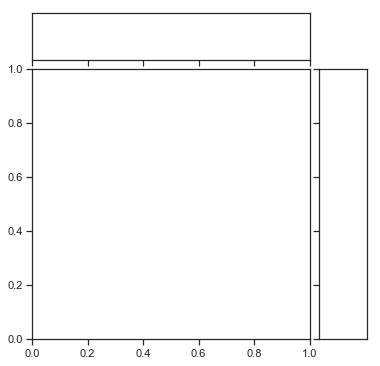

In [182]:
x = tmdb_df_revenue["roi"]
x = tmdb_df_revenue["budget"]
sns.jointplot(x = "x", y = "y", data = tmdb_df_revenue, kind = "kde");

In [18]:
most_successful_pc_roi = tmdb_df_revenue.groupby("production_companies")["roi"].mean()
most_successful_pc_roi.sort_values(ascending = False)

production_companies
First Artists                           167.571429
Orange Sky Golden Harvest               136.104790
Otis Productions                         99.000000
Kennedy Miller Productions               87.641146
Max Baer Productions                     79.000000
Cupid Productions                        54.589466
Pak Nishan Films                         53.054054
The Universal Film Mfg. Co.              39.000000
Viacom 18 Motion Pictures                35.534272
Aamir Khan Productions                   28.807692
Spring Era Film Company                  28.303794
Carolco International N.V.               25.131792
D'Antoni Productions                     21.865976
Tatira-Hiller Productions                19.280000
Foster-Brower Productions                16.549982
Kent Productions                         15.912624
Sil-Metropole Organisation Ltd.          15.600191
United Artists                           15.479555
Fuji Television Network                  15.428591
Diablo Ent

/Users/florencialeoni/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


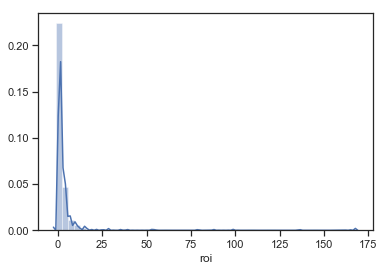

In [153]:
x = most_successful_pc_roi
sns.distplot(x)

In [19]:
most_successful_pc_rev = tmdb_df.groupby("production_companies")["revenue"].mean()
most_successful_pc_rev.sort_values(ascending = False)

production_companies
Truenorth Productions                                   2.068224e+09
Abu Dhabi Film Commission                               1.506249e+09
Illumination Entertainment                              1.156731e+09
Ingenious Film Partners                                 1.078562e+09
Danjaq                                                  9.946178e+08
Hasbro Studios                                          9.402898e+08
Blue Sky Studios                                        8.866868e+08
Marvel Studios                                          8.714689e+08
Spring Era Film Company                                 8.703227e+08
Avi Arad Productions                                    8.550140e+08
Etalon film                                             7.886798e+08
Heineken Branded Entertainment                          7.385997e+08
Fuji Television Network                                 6.516815e+08
Pixar                                                   6.314421e+08
GH Three     

In [135]:
# Function to create a new SQLite3 Database
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    finally:
        conn.close()

In [136]:
# Use create_connection function to create Database
create_connection("/Users/florencialeoni/Documents/flatironDS/Mod_1_FP/mod1_movies/movies.db")

In [137]:
# Create a connection object using the connect function 
# To establish a connection with "movies.db"
connection = sqlite3.connect("movies.db")
# Create a cursor object by calling the cursor method
cursor = connection.cursor()

In [145]:
# Write records stored in the imdb_df DataFrame to a SQL database
imdb_df.to_sql("imdb_movies", con = connection)

In [ ]:
# Write records stored in the tmdb_df DataFrame to a SQL database
tmdb_df.to_sql("tmdb_movies", con = connection)

In [214]:
combined_df = pd.read_sql_query('''
SELECT
    id,
    title, 
    belongs_to_collection, 
    budget, 
    genres,
    overview, 
    revenue, 
    tagline, 
    director_name,
    leading_actor_name,
    supporting_actor_name,
    vote_average, 
    vote_count, 
    runtime, 
    popularity, 
    production_companies,
    year,
    month_of_year,
    day_of_week,
    tmdb_movies.imdb_id AS tmdb_imdb_id,
    imdb_movies.imdb_id AS imdb_id,
    imdb_score
    meta_score
FROM
    tmdb_movies
    INNER JOIN imdb_movies ON tmdb_movies.imdb_id = imdb_movies.imdb_id;''', connection)

In [138]:
pd.read_sql_query('''SELECT title, MAX(popularity) FROM tmdb_movies''', connection)

title  MAX(popularity)
0  Bumblebee          226.241

In [216]:
pd.read_sql_query('''SELECT title, MAX(revenue) FROM tmdb_movies''', connection)

title  MAX(revenue)
0  Avatar  2.787965e+09

In [217]:
pd.read_sql_query('''SELECT title, MAX(budget) FROM tmdb_movies''', connection)

title  MAX(budget)
0  Justice League  500000000.0

In [218]:
pd.read_sql_query('''SELECT title, MIN(budget) FROM tmdb_movies''', connection)

title  MIN(budget)
0  The Hunted          1.0

In [340]:
pd.read_sql_query('''SELECT title, MIN(popularity) FROM tmdb_movies''', connection)

title  MIN(popularity)
0  Resident Evil: Afterlife              0.6

In [144]:
pd.read_sql_query('''SELECT title, revenue, budget, vote_count, year, genres FROM tmdb_movies WHERE production_companies LIKE "%lionsgate%";''', connection)

title      revenue       budget  vote_count    year                                             genres
0                           Power Rangers  142337240.0  100000000.0      2569.0  2017.0         ['Action', 'Adventure', 'Science Fiction']
1                                 Sicario   84025816.0   30000000.0      4311.0  2015.0                    ['Action', 'Crime', 'Thriller']
2                        The Hunger Games  691210692.0   75000000.0     14140.0  2012.0        ['Science Fiction', 'Adventure', 'Fantasy']
3         The Hunger Games: Catching Fire  847423452.0  130000000.0     10790.0  2013.0         ['Adventure', 'Action', 'Science Fiction']
4                               Abduction   82087155.0   35000000.0      1720.0  2011.0                  ['Thriller', 'Action', 'Mystery']
5   The Hunger Games: Mockingjay - Part 1  752100229.0  125000000.0      9756.0  2014.0       ['Science Fiction', 'Adventure', 'Thriller']
6                            3:10 to Yuma   70016220.0   55000000.0      1779.0  2007.0                                        ['Western']
7                             Hummingbird    8352885.0   20000000.0       823.0  2013.0                             ['Action', 'Thriller']
8                      Punisher: War Zone   10089373.0   20500000.0       518.0  2008.0                                ['Action', 'Crime']
9                     Crank: High Voltage   34560577.0   20000000.0      1377.0  2009.0                    ['Action', 'Thriller', 'Crime']
10                            Daybreakers   51416464.0   20000000.0       972.0  2009.0  ['Action', 'Fantasy', 'Horror', 'Science Ficti...
11              My Little Pony: The Movie   60330833.0          NaN       130.0  2017.0  ['Music', 'Adventure', 'Animation', 'Family', ...
12                              Mortdecai   30418560.0   60000000.0      1604.0  2015.0                            ['Comedy', 'Adventure']
13                                    War   40452643.0   25000000.0       676.0  2007.0                    ['Action', 'Thriller', 'Crime']
14                       Life on the Line          NaN          NaN        80.0  2015.0                                ['Action', 'Drama']
15                    A Gnome Named Gnorm          NaN    5000000.0        23.0  2015.0                    ['Thriller', 'Action', 'Crime']
16                         Commando Ninja          NaN    1000000.0        13.0  2010.0                ['Adventure', 'Action', 'Thriller']

In [24]:
tmdb_runtime = tmdb_df[tmdb_df["runtime"] > 0][["runtime", "year", "popularity", "imdb_score", 
                                                "meta_score", "budget", "revenue"]].sort_values("popularity", ascending = False)

In [25]:
tmdb_df_rel = tmdb_df[tmdb_df["imdb_id"].notnull()][["title", "runtime", "year", 
                        "month_of_year", "day_of_week", "popularity"]]

tmdb_df_revenue_rel = tmdb_df[tmdb_df["revenue"].notnull()][["title", "budget", "revenue", "runtime", "year", 
                        "month_of_year", "day_of_week", "popularity"]]

/Users/florencialeoni/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/florencialeoni/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


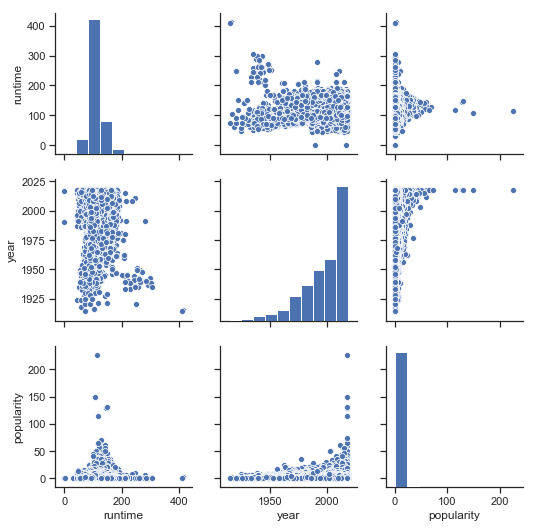

In [26]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(tmdb_df_rel)

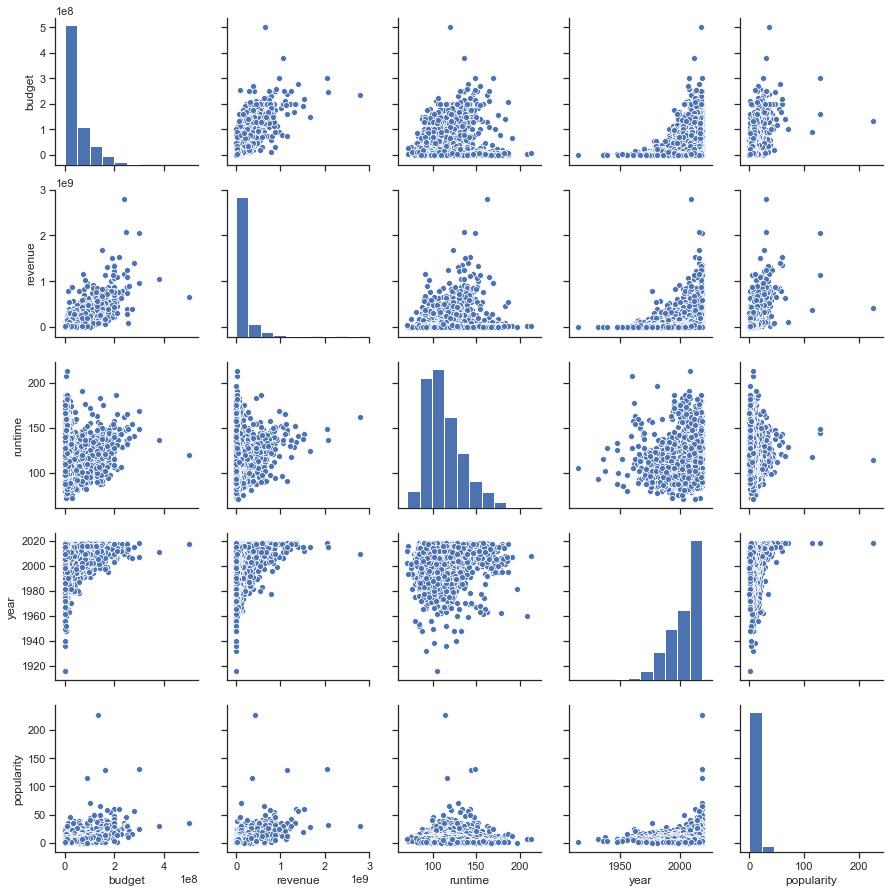

In [27]:
sns.pairplot(tmdb_df_revenue_rel)

In [152]:
less_popular = tmdb_df[tmdb_df["imdb_score"].notnull()][["title", 
                        "vote_count", "year", "overview", "meta_score", "production_companies",
                            "genres", "budget"]].sort_values("vote_count").head(200)

less_popular

title  vote_count    year                                           overview meta_score                               production_companies                                             genres      budget
6296                                      The Dark Mist         1.0  1990.0  Unable to tolerate the worries of the villager...        NaN                                                NaN                                          ['Drama']         NaN
7176                                               Luck         1.0  1978.0  Former TV documentary filmmaker Mel Stuart tri...        NaN                                                NaN                                                NaN         NaN
7173                                          Parvarish         1.0  2017.0  According to the police, Negar's father commit...        NaN                                       Hedayat Film                   ['Crime', 'Mystery', 'Thriller']         NaN
3854                       Pokémon: The Rise of Darkrai         1.0  1972.0  In a Middle Eastern country, a traveling Ameri...        NaN                                                NaN                                                NaN         NaN
7165                                    Nowhere to Hide         1.0  2017.0  An un-ethical DEA agent does everything in his...        NaN                                                NaN                       ['Action', 'Crime', 'Drama']         NaN
2615                                         Blood Ride         1.0  2017.0  Maggie becomes a strong and ruthless member of...        NaN                                                NaN                                         ['Action']         NaN
7156                           Octopus 2: River of Fear         1.0  1995.0                            Overview Coming Soon...        NaN                                                NaN                                ['Action', 'Drama']         NaN
3874                            The Trial of Billy Jack         1.0  1992.0  Mike Yarnell is a burnt out cop, who is being ...        NaN                        Amritraj Entertainment Inc.                                       ['Thriller']         NaN
7150                                       Dharam Kanta         1.0  2012.0  Mirza – The Untold Story is based on the legen...        NaN                                                NaN                      ['Action', 'Comedy', 'Crime']         NaN
7149                                          Khule-Aam         1.0  2012.0  A man falls in love with a beautiful girl, who...        NaN                                 R. S. Infotainment                   ['Drama', 'Thriller', 'Romance']         NaN
7148                                         Shaker Run         1.0  1988.0  Investigative journalist Alf Winters (Morrison...        NaN                                      Everard Films                              ['Drama', 'Thriller']         NaN
7196                           Devudu Chesina Manushulu         1.0  1995.0  Trent Turner has it all - a beautiful wife, a ...        NaN                         James Shavick Film Company                    ['Thriller', 'Drama', 'Action']         NaN
7140                      The Incredible Paris Incident         1.0  2017.0  One day, while conducting such smuggling, they...        NaN                           G21 Production Pvt. Ltd.                               ['Comedy', 'Action']         NaN
7136                                              Boned         1.0  1977.0  A policeman adopts the son of a bandit. A misu...        NaN                                         A.G. Films                       ['Drama', 'Action', 'Crime']         NaN
7122                                           The Kick         1.0  2018.0  The storyline of the film is based on the appr...        NaN                                                NaN                             ['Action', 'Thriller']         NaN
7097              

In [29]:
less_popular_title = pd.Series(' '.join(less_popular["title"]).lower().split()).value_counts()[:200]

In [30]:
less_popular_overview = pd.Series(' '.join(less_popular["overview"]).lower().split()).value_counts()[:200]

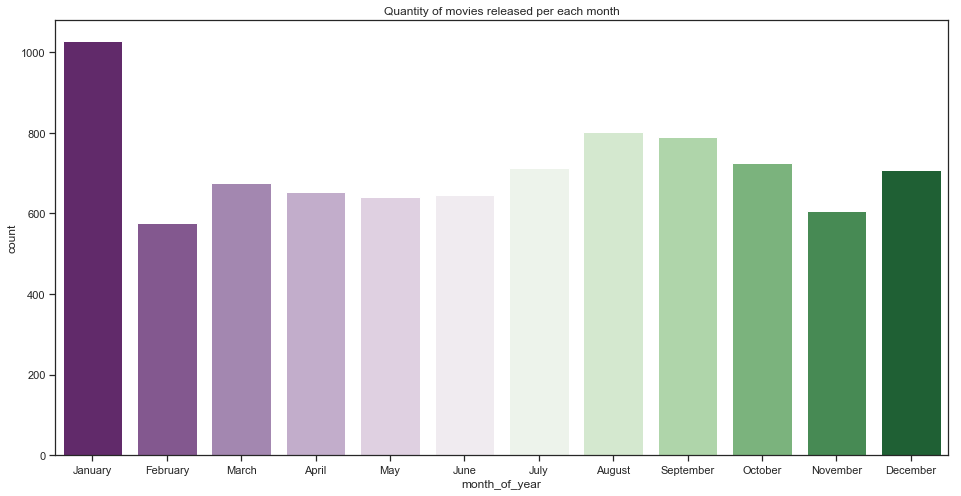

In [31]:
plt.figure(figsize=(16,8))
plt.title("Quantity of movies released per each month")
sns.countplot(x = "month_of_year", data = tmdb_df, palette = "PRGn", order = ["January", "February", 
                                                                              "March", "April", "May",
                                                                             "June", "July", "August",
                                                                             "September", "October",
                                                                             "November", "December"])

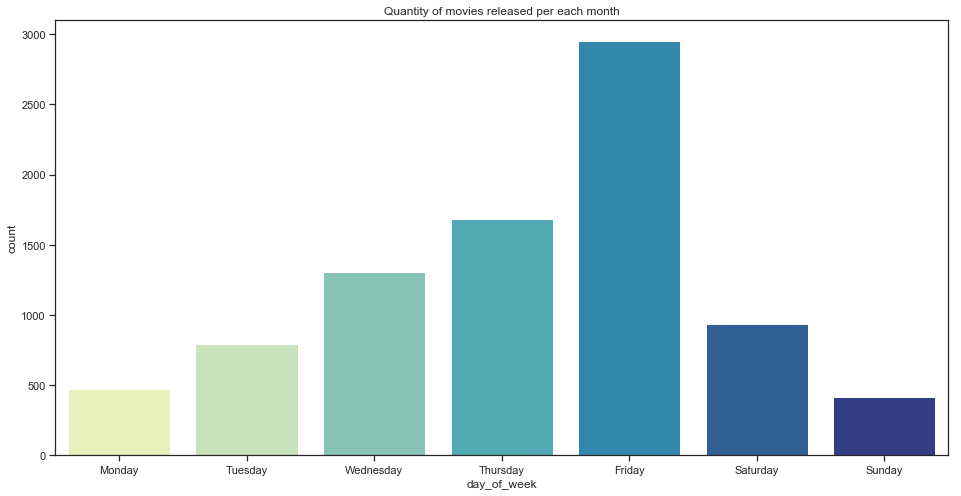

In [32]:
plt.figure(figsize=(16,8))
plt.title("Quantity of movies released per each month")
sns.countplot(x = "day_of_week", data = tmdb_df, palette = "YlGnBu", order = ["Monday", "Tuesday", 
                                                                              "Wednesday", "Thursday", "Friday",
                                                                             "Saturday", "Sunday"])

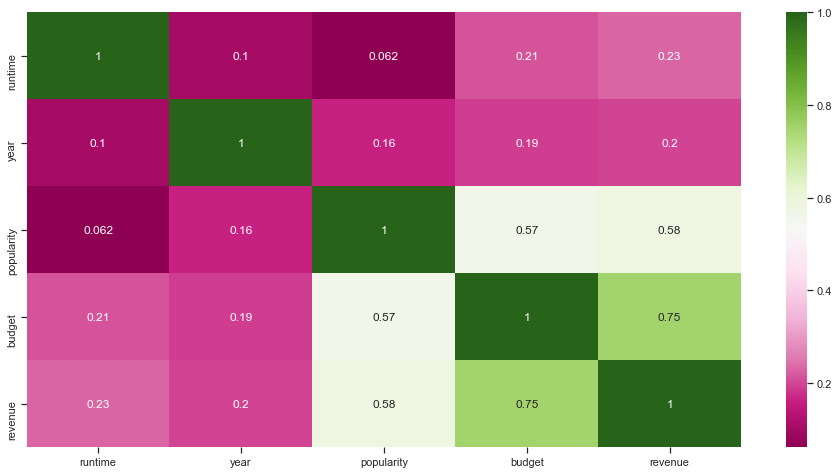

In [33]:
plt.figure(figsize = (16, 8))
sns.heatmap(tmdb_runtime.corr(), annot = True, cmap = "PiYG")

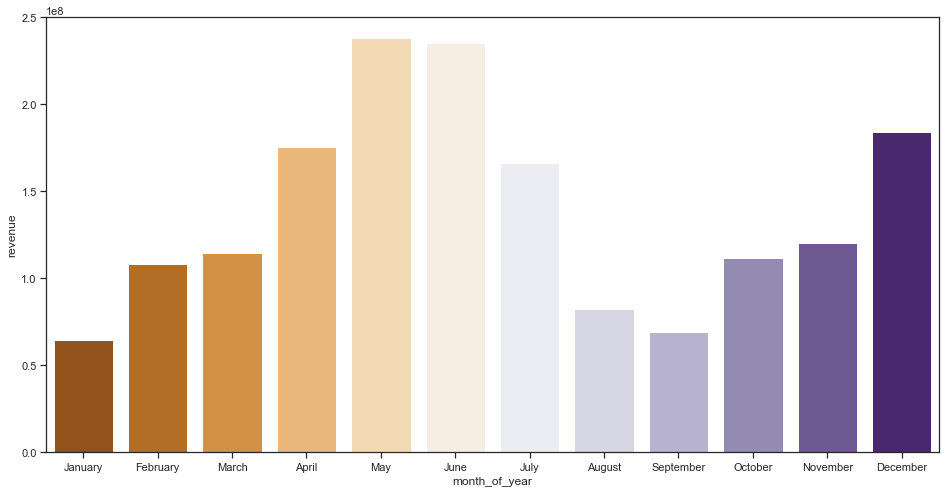

In [34]:
month_df = tmdb_df_revenue[tmdb_df_revenue["month_of_year"].notnull()][["revenue", "month_of_year"]]
avg_rev_month = month_df.groupby("month_of_year").mean()
avg_rev_month.reset_index(inplace = True)
plt.figure(figsize = (16, 8))
sns.barplot(x = "month_of_year", y = "revenue", palette = "PuOr", data = avg_rev_month, order = ["January", "February", 
                                                                              "March", "April", "May",
                                                                             "June", "July", "August",
                                                                             "September", "October",
                                                                             "November", "December"])

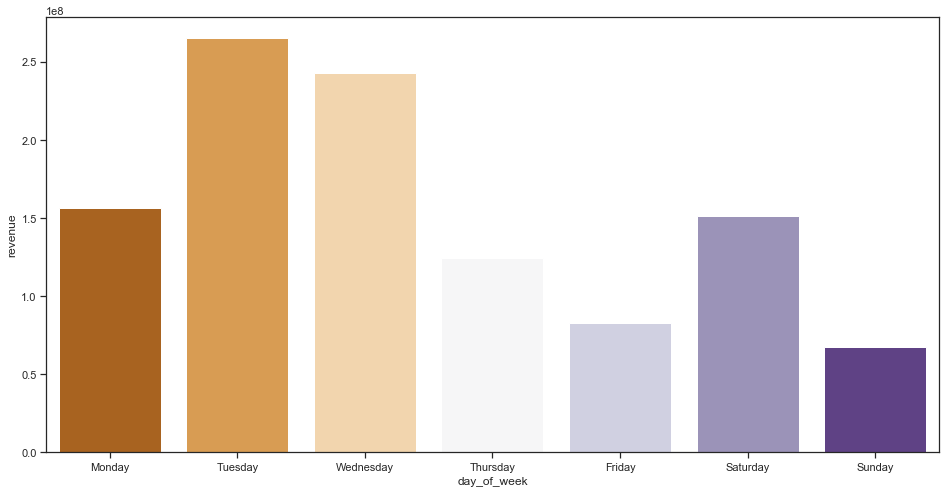

In [35]:
day_df = tmdb_df_revenue[tmdb_df_revenue["day_of_week"].notnull()][["revenue", "day_of_week"]]
avg_rev_day = day_df.groupby("day_of_week").mean()
avg_rev_day.reset_index(inplace = True)
plt.figure(figsize = (16, 8))
sns.barplot(x = "day_of_week", y = "revenue", palette = "PuOr", data = avg_rev_day, order = ["Monday", "Tuesday", 
                                                                              "Wednesday", "Thursday", "Friday",
                                                                             "Saturday", "Sunday"])

In [114]:
filtered_genres_df = genres_df[genres_df['year'] < 2012]
grouped_by = filtered_genres_df.groupby(["genre_0"])["revenue"].mean()

grouped_by.mean().plot(kind = "bar", stacked = False, figsize = (14, 6))
grouped_by


# DataFrameGroupBy.plot(most_successful_genre, x = "genre_0", y = "revenue")
# df.groupby(['state','gender'])['name'].size().unstack().plot(kind='bar',stacked=True)
# most_successful_genre.reset_index(inplace = True)
# sns.catplot(x = "genre_0", y = "revenue", kind = "swarm", data = most_successful_genre, palette = "PiYG");


genre_0
Action             7.943091e+07
Adventure          1.905062e+08
Animation          1.511780e+08
Comedy             5.219657e+07
Crime              3.880232e+07
Documentary                 NaN
Drama              5.334698e+07
Family             5.472943e+07
Fantasy            1.640205e+08
History            1.197001e+08
Horror             6.558213e+07
Music              2.215944e+07
Mystery            8.507212e+07
Romance            3.670327e+07
Science Fiction    1.062726e+08
Thriller           7.742510e+07
War                2.963419e+07
Western            3.521905e+07
Name: revenue, dtype: float64

In [96]:
pd.Series(' '.join(less_popular["title"]).lower().split()).value_counts()[:15]


the      29
of        6
and       3
on        3
in        3
heist     2
red       2
2:        2
other     2
hard      2
devil     2
for       2
girl      2
a         2
kasam     1
dtype: int64

In [99]:
pd.Series(' '.join(less_popular["overview"]).lower().split()).value_counts()[:100]

the         255
a           219
to          184
and         159
of          135
in          109
is          106
his          90
he           77
with         58
for          47
by           43
who          37
an           36
that         36
her          35
as           33
but          31
are          28
him          28
on           26
from         26
she          24
when         23
they         22
be           21
after        21
police       19
their        19
out          17
           ... 
her.          7
boy           7
years         7
have          7
so            7
very          6
local         6
son           6
can           6
drug          6
three         6
war           6
criminal      6
mother        6
movie         6
through       6
best          6
meets         6
become        6
do            6
father        6
little        6
wife          6
named         6
must          5
rescue        5
new           5
time          5
him.          5
tries         5
Length: 100, dtype: int6